In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot

In [3]:
dt.config()

In [4]:
lc = 0.5
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")

print(up_bnd_nodes_idx)

[2, 3, 6]


In [40]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.02
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, up_bnd_pos_components]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]

In [41]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
                   "1": (up_bnd_nodes_idx, up_bnd_nodes_pos_y),
                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
print(boundary_values)
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
obj = ela.obj_linear_elasticity_energy
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}
x0 = S.node_coords.flatten()

{'0': ([2, 3, 6], array([1.02, 0.02, 0.52])), '1': ([2, 3, 6], array([1., 1., 1.])), ':': ([0, 1, 4], array([[0. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0.5, 0. , 0. ]]))}


In [28]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.run(x0=x0, ftol_abs=1e-9, ftol_rel=1e-9)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)

1


In [36]:
strain = ela.get_GreenLagrange_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[-2.44735334e-03  7.99541905e-03]
  [ 7.99541905e-03  4.59676056e-03]]

 [[-2.26744786e-03  8.28163365e-03]
  [ 8.28163365e-03  4.35445911e-03]]

 [[-8.55128969e-07  9.03060782e-03]
  [ 9.03060782e-03  5.89918053e-04]]

 [[-1.74742232e-06  8.77113865e-03]
  [ 8.77113865e-03  6.74733547e-04]]

 [[-1.87486764e-06  8.39026672e-03]
  [ 8.39026672e-03 -5.71181627e-04]]

 [[ 3.20066442e-03  8.18530682e-03]
  [ 8.18530682e-03 -4.18364071e-03]]

 [[-9.10959034e-07  8.29686878e-03]
  [ 8.29686878e-03 -7.07969176e-04]]

 [[ 3.01786329e-03  8.18850520e-03]
  [ 8.18850520e-03 -3.94347059e-03]]

 [[-4.97466938e-04  9.26963808e-03]
  [ 9.26963808e-03 -8.58683544e-04]]

 [[-7.29068255e-04  9.73755939e-03]
  [ 9.73755939e-03 -7.55402930e-04]]

 [[ 5.65813065e-04  1.20234169e-02]
  [ 1.20234169e-02  2.88056207e-04]]

 [[-1.16331671e-03  8.31792139e-03]
  [ 8.31792139e-03  2.43956169e-04]]

 [[ 8.31124403e-04  1.19605206e-02]
  [ 1.19605206e-02  1.42197348e-04]]

 [[-8.58298973e-04  7.97742408

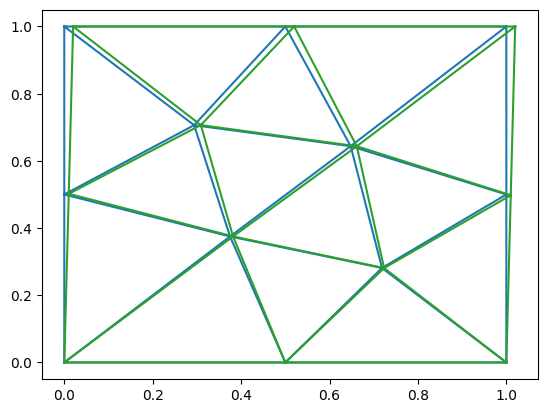

In [30]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [35]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values))
print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values))
node_coords_coch = C.CochainP0(complex=S, coeffs=curr_node_coords)
f_coch = C.CochainP2(complex=S, coeffs=f)
elastic_energy = ela.elasticity_energy(node_coords_coch, f_coch)
print(elastic_energy)

0.0003570145714351798
0.00040047999999999836
0.0003564701105495012


In [34]:
print(true_curr_node_coords)
print(curr_node_coords)

[[0.         0.         0.        ]
 [1.         0.         0.        ]
 [1.02       1.         0.        ]
 [0.02       1.         0.        ]
 [0.5        0.         0.        ]
 [1.01       0.5        0.        ]
 [0.52       1.         0.        ]
 [0.01       0.5        0.        ]
 [0.307875   0.70625    0.        ]
 [0.3825     0.375      0.        ]
 [0.66079167 0.64375    0.        ]
 [0.724375   0.28125    0.        ]]
[[ 6.55340103e-06  1.04230546e-05  0.00000000e+00]
 [ 1.00000519e+00 -7.44957794e-06  0.00000000e+00]
 [ 1.01999331e+00  9.99989711e-01  0.00000000e+00]
 [ 1.99946392e-02  1.00000751e+00  0.00000000e+00]
 [ 5.00006126e-01 -1.38841409e-06  0.00000000e+00]
 [ 1.00999685e+00  4.97796072e-01  0.00000000e+00]
 [ 5.19994184e-01  1.00000119e+00  0.00000000e+00]
 [ 1.01870672e-02  5.02079728e-01  0.00000000e+00]
 [ 3.08866249e-01  7.06502374e-01  0.00000000e+00]
 [ 3.81788057e-01  3.75161425e-01  0.00000000e+00]
 [ 6.61652959e-01  6.43562430e-01  0.00000000e+00]
 [ 7.2